## Load libraries

In [1]:
import os
import pandas as pd
import numpy as np
import h5py
from sklearn.metrics import classification_report

from alphai_watson.performance import GANPerformanceAnalysis
from alphai_watson.transformer import NullTransformer
from alphai_rickandmorty_oracle.datasource.mnist import MNISTDataSource
from alphai_rickandmorty_oracle.detective import RickAndMortyDetective
from alphai_rickandmorty_oracle.model_mnist import RickAndMorty

from matplotlib import pyplot as plt

/opt/anaconda/envs/ai/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/opt/anaconda/envs/ai/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
DEBUG:matplotlib:CACHEDIR=/home/ubuntu/.cache/matplotlib
DEBUG:matplotlib.font_manager:Using fontManager instance from /home/ubuntu/.cache/matplotlib/fontList.json
DEBUG:matplotlib.backends:backend agg version v2.2


Enabling weight norm
Uppercase local vars:
	BATCH_SIZE: 50
	CRITIC_ITERS: 5
	DEFAULT_FIT_EPOCHS: 1000
	DEFAULT_LEARN_RATE: 0.0001
	DEFAULT_TRAIN_ITERS: 5000
	DEFAULT_Z_DIM: 200
	DIAGNOSIS_LEARN_RATE: 0.01
	DIM: 64
	DISC_FILTER_SIZE: 5
	INIT_KERNEL: <tensorflow.python.ops.init_ops.RandomNormal object at 0x7ff02940b128>
	LAMBDA: 10
	LAMBDA_2: 2.0
	OUTPUT_DIM: 784


## Define MNIST Datasource

In [2]:
file_path = '../../tests/resources'

abnormal_digit = 4

# Train and test data file
train_data_file = os.path.join(file_path, 'mnist_data_train_abnormalclass-{}.hd5'.format(abnormal_digit))
test_data_file = os.path.join(file_path, 'mnist_data_test_abnormalclass-{}.hd5'.format(abnormal_digit))

# Model parameters
n_sensors = 28
n_timesteps = 784 // n_sensors

train_data_source = MNISTDataSource(source_file=train_data_file, 
                                    transformer=NullTransformer(number_of_timesteps=n_timesteps,
                                                                number_of_sensors=n_sensors))
test_data_source = MNISTDataSource(source_file=test_data_file,
                                   transformer=NullTransformer(number_of_timesteps=n_timesteps,
                                                               number_of_sensors=n_sensors))

train_data = train_data_source.get_train_data('NORMAL')

DEBUG:root:Start file parsing.
DEBUG:root:Processing sample type NORMAL.
DEBUG:root:End file parsing.
DEBUG:root:Start file parsing.
DEBUG:root:Processing sample type ABNORMAL.
DEBUG:root:Processing sample type NORMAL.
DEBUG:root:End file parsing.


### Plot input images to verify correctness

DEBUG:matplotlib.backends:backend module://ipykernel.pylab.backend_inline version unknown
DEBUG:matplotlib.backends:backend module://ipykernel.pylab.backend_inline version unknown
DEBUG:matplotlib.font_manager:findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to DejaVu Sans ('/opt/anaconda/envs/ai/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000


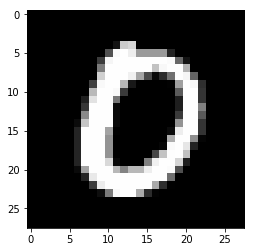

In [3]:
%matplotlib inline
# First row is first image
idx = len(train_data.data)
image = train_data.data[np.random.randint(0, idx)]

# h_train = h5py.File(test_data_file)
# image = np.array(h_train.get('ABNORMAL'))[156]

# 784 columns correspond to 28x28 image
plottable_image = np.reshape(image, (28, 28))

# Plot the image
plt.imshow(plottable_image, cmap='gray')
plt.show()

## Define Model

In [4]:
model_dir = './mnist_models'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

batch_size = 64
output_dimensions = 784
train_iters = 10000
plot_save_path = model_dir

model = RickAndMorty(batch_size=batch_size, 
                     output_dimensions=output_dimensions, 
                     train_iters=train_iters,
                     plot_save_path=plot_save_path)

detective = RickAndMortyDetective(model_configuration={
    'model': model,
    'batch_size': batch_size,
    'output_dimensions': output_dimensions,
    'train_iters': train_iters,
    'save_path' : '{}/MNIST-abnormalclass-{}'.format(model_dir, abnormal_digit),
    'plot_save_path' : plot_save_path
})

detective.train(train_data)

## Evaluate Results

### Load trained model

In [5]:
# detective = RickAndMortyDetective(model_configuration={
#     'model': model,
#     'batch_size': batch_size,
#     'output_dimensions': output_dimensions,
#     'train_iters': train_iters,
#     'load_path' : '{}/MNIST-abnormalclass-{}'.format(model_dir, abnormal_digit),
#     'plot_save_path' : plot_save_path
# })

### Load test data


In [31]:
# Get test data
test_data_normal = test_data_source.get_train_data('NORMAL')
test_data_abnormal = test_data_source.get_train_data('ABNORMAL')
test_data = test_data_source.get_train_data('ALL')

# Ground truth for ABNORMAL data is 0, ground truth for NORMAL data is 1
n1 = np.zeros(len(test_data_abnormal.data))
n2 = np.ones(len(test_data_normal.data))
expected_truth = np.hstack((n1, n2))

### Calculate ROC Score

In [32]:
detection_result = detective.detect(test_data)

roc_score = GANPerformanceAnalysis({}).analyse(
  detection_result=detection_result.data,
  expected_truth=expected_truth
)

print('ROC Score: {}'.format(roc_score))

INFO:root:Running detector on <alphai_watson.datasource.Sample object at 0x7ff022a7b2b0>
INFO:root:Detection completed in 0.7729969508945942


ROC Score: 0.49638922079939074


### Generate classification report

In [37]:
results = detection_result.data
threshold = np.median(results)
prediction = [1 if x >= threshold else 0 for x in results]

target_names = ['ABNORMAL', 'NORMAL']
print(classification_report(expected_truth, prediction, target_names=target_names))

              precision    recall  f1-score   support

    ABNORMAL       0.35      0.49      0.41      6824
      NORMAL       0.64      0.50      0.56     12636

   micro avg       0.50      0.50      0.50     19460
   macro avg       0.50      0.49      0.48     19460
weighted avg       0.54      0.50      0.51     19460

